# GRB Source injector

The "source injector" is a cosipy module that will generate mocked binned data based on the detector response and a source hypothesis (provided by the users). This should result in the same output as simulating the source using MEGAlib, but be much quicker. MEGAlib is only needed when the event-by-event data is required, or to create the detector response itself. 

The goal of this notebook is to get an idea how the source injector will work in practice. We need to take it from here to something that is user friendly and compatible with the rest of the modules.

First, let's load all dependecies:

In [1]:
# We'll use histpy's Histogram and mhealpy's HealpixMap as the basis
# develop cosipy. These object (or a derivative) will be passed around by 
# the different modules.
from histpy import Histogram
from mhealpy import HealpixMap

from cosipy.response import FullDetectorResponse
from cosipy.coordinates.orientation import Orientation_file
from cosipy.spacecraftpositionattitude import SpacecraftPositionAttitude
from cosipy.ts_map.TSMap import TSMap

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band


#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt

/Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/numba-0.57.0rc1-py3.10-macosx-10.9-x86_64.egg/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',


08:54:59 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=486351;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=74509;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=80089;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=809035;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

/Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/numba-0.57.0rc1-py3.10-macosx-10.9-x86_64.egg/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=567084;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=39921;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

/Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/numba-0.57.0rc1-py3.10-macosx-10.9-x86_64.egg/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',


         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=29763;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=631989;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=72611;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=998801;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=490276;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=628467;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=97968;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=835206;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=53607;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=338285;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=648905;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=685841;file:///Users/ckierans/Software/COSItools/astromodels-2.4.0/astromodels/core/parameter.py#704\704]8;;\

08:54:59 INFO      Starting 3ML!                                                                     ]8;id=66813;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=488489;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=98877;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=480722;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=226120;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=62755;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=870227;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=152137;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

08:55:00 WARNING   ROOT minimizer not available                                                ]8;id=787830;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=39265;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=420566;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=496059;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=923345;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=538421;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\


WARNING NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



08:55:00 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=836595;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=813631;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=895880;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=789700;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=320555;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=720383;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

08:55:01 WARNING   No fermitools installed                                              ]8;id=357588;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=719606;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

08:55:01 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=453037;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=265094;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=724171;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=941918;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=876844;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=825186;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Load the response and orientation files

In [2]:
response_path = "/Users/ckierans/Software/COSItools/COSItools/intro_cosipy/test_data/FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5"
response = FullDetectorResponse.open(response_path)

ori = Orientation_file.parse_from_file("/Users/ckierans/Software/COSItools/COSItools/cosipy/20280301_first_2hrs.ori")

Timemin = Time(1835481433.0,format = 'unix')
Timemax = Time(1835481435.0,format = 'unix')
grbori = ori.source_interval(Timemin, Timemax)

Text(0, 0.5, 'Latitude [deg]')

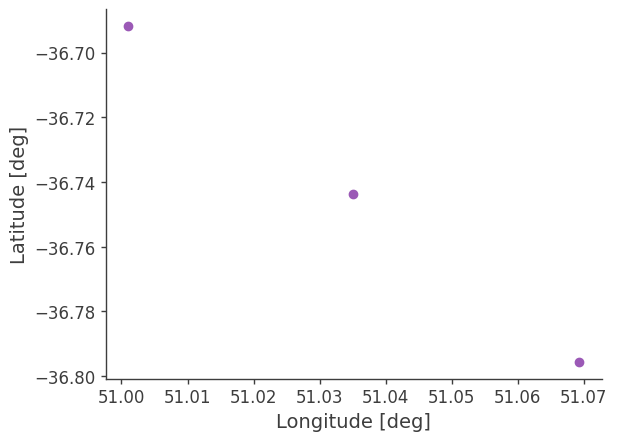

In [4]:
# you can plot the pointings to see how the zenith changes over the observation - shown in Galactic Coordinates
plt.plot(grbori._z_direction[:,1], grbori._z_direction[:,0],"o")
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")

In [5]:
# Simulating a 2 second GRB at l = 51, b = -17 in Galacti coordinates.
coord = SkyCoord(l = 51*u.deg, b = -17*u.deg,
                 frame = 'galactic', attitude = Attitude.identity(frame = 'galactic')) 

In [6]:
# Initiate a SpacecraftPositionAttitude object with the coordinates of the source
SCPosition = SpacecraftPositionAttitude.SourceSpacecraft("GRB", coord) 

Now converting to the Spacecraft frame...
Conversion completed!


Text(0, 0.5, 'Latitude [deg]')

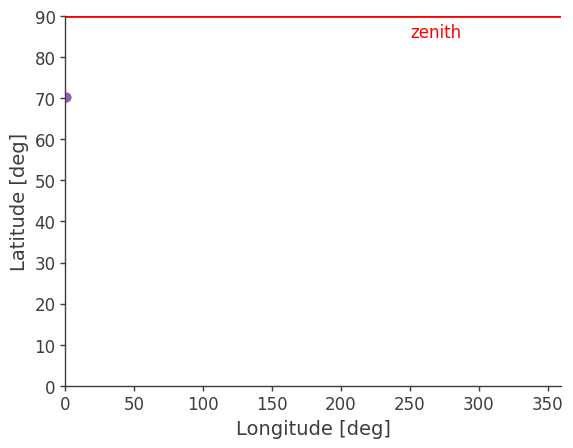

In [7]:
# From the orientation, get the attitude and define the source movement in the spacecraft FOV
x,y,z = grbori.get_attitude().as_axes()
dts = grbori.get_time_delta()

src_movement = SCPosition.sc_frame(x_pointings = x[:], y_pointings = y[:], z_pointings = z[:])

# The source should be 20 degrees off axis for this simulation, based on the GRB ori file.
# Zenith is Latitude = 90, therefore, we expect this to be at Latitude = 90-20 = 70, and Longitude = 0.

plt.plot(src_movement.lon.deg, src_movement.lat.deg,"o")
plt.ylim(0,90)
plt.xlim(0,360)
plt.axhline(y=90, color='r', linestyle='-')
plt.annotate("zenith",[250,85], color='r')
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")

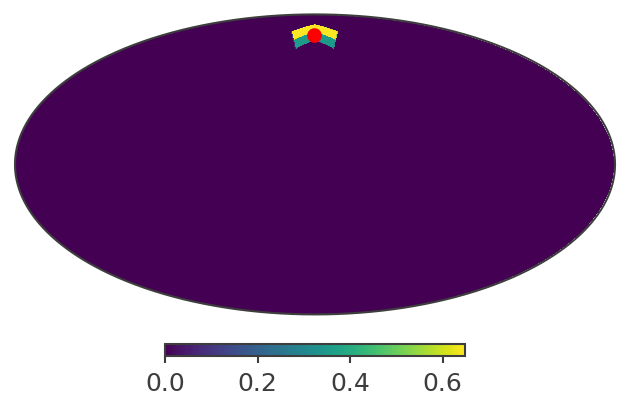

In [11]:
dwell_time_map = SCPosition.get_dwell_map(response = response_path, dts = dts, src_path = src_movement[:-1])
#dwell time map has the correct distribution in detector coordinates with a hot spot 20 degrees from zenith

_,ax = dwell_time_map.plot(ax_kw = {'coord':'C'}, coord = SpacecraftFrame(attitude = Attitude.identity(frame ='icrs')))

#Need to use the same transformation to plot the coordinates of the source
c_sc = coord.transform_to(SpacecraftFrame(attitude = Attitude(grbori.get_attitude())))
ax.scatter(c_sc[0].lon.deg, c_sc[0].lat.deg, transform=ax.get_transform('world'), color = 'red')

The sum of all pixel in the dwell time map is simply the duration of the data that was integrated. In this case is just the duration of the GRB.

In [12]:
print(sum(dwell_time_map))

2.00000000000351 s


The detector response is then convolved with the dwell time map to get the point source response:

The point source response is still quite generic. We obtained the response for a give location and duration, but we still convolved this with a given spectral assumption:

In [13]:
psr = response.get_point_source_response(dwell_time_map)

In [14]:
# Set the spectra of the source
spectrum = Band()
alpha = -1
beta = -3 
xp = 1000 * u.keV
piv = 500 * u.keV
K = 0.00247 / u.cm / u.cm / u.s / u.keV
spectrum.alpha.value = alpha
spectrum.beta.value = beta
spectrum.xp.value = xp.value
spectrum.xp.unit = xp.unit
spectrum.K.value = K.value
spectrum.K.unit = K.unit
spectrum.piv.value = piv.value
spectrum.piv.unit = piv.unit
    
# We project into the only event parameters that we can measure in COSI
signal = psr.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi'])

The result `signal` is histogram that contains the expected counts in measured energy (`Em`) and the "Compton Data Space": Compton scatter angle (`Phi`) and direction (in SC coordinates) of the scattered photon in he (`PsiChi`). For reference, see the following figure from [this](https://arxiv.org/abs/2102.13158) paper. The only different is that here we are using spacecraft coordinate instead of galactic coordinates. ![](cds.png)

The `signal` object is a 3D histogram. Note that the last axis, `PsiChi`, is actually a 2D axis encoding the coordinates in a sphere as pixels in a HEALPix grid. So, in a sense, it's really a 4D histogram.

In [15]:
signal.axes.labels

array(['Em', 'Phi', 'PsiChi'], dtype='<U6')

Let's explore this simulated signal and see how it looks.

First, we can get the measured energy distribution by projecting the histogram into the `Em`:

(<AxesSubplot: xlabel='Em [keV]'>, <ErrorbarContainer object of 3 artists>)

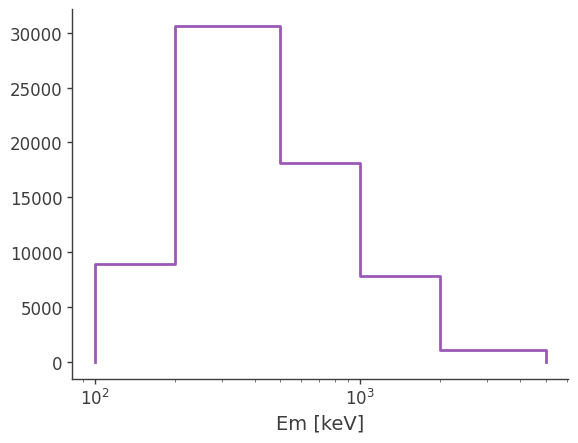

In [16]:
signal.project('Em').plot()

This shape is a combination of the spectrum, the energy resolution, and the effective area of the detector as a function of energy.

We can get the total number of events we expect from the GRB by summing over all bins:

In [17]:
np.sum(signal)

66479.07966849873

Now let's explore the CDS. It's easier to visualize if we take slices in energy and scatter angle. For reference, these are the bin edges:

In [18]:
signal.axes['Em'].edges

<Quantity [ 100.,  200.,  500., 1000., 2000., 5000.] keV>

In [19]:
signal.axes['Phi'].edges

<Quantity [  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.,
           100., 110., 120., 130., 140., 150., 160., 170., 180.] deg>

This is the plot of the distribution of events within the energy range 1-2 MeV (bin 3) and scattered angles between 40-50deg (bin 4):

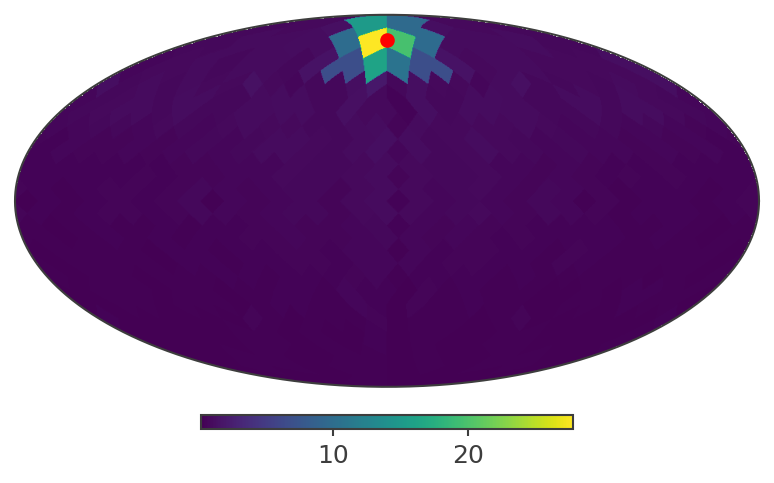

In [20]:
#Since `PsiChi` is encoded as pixel in a HEALPix grid, we need mhealpy to render it back to a sphere
m_signal = HealpixMap(signal.slice[{'Em':3, 'Phi':0}].project('PsiChi').todense().contents,
                      coordsys = SpacecraftFrame(attitude = grbori.get_attitude()))

fig = plt.figure(dpi = 150)

# Try also other projections, e.g. projection = 'orthview'
ax = fig.add_subplot(projection = 'mollview')

m_signal.plot(ax, coord = SpacecraftFrame(attitude = Attitude.identity(frame ='icrs')))

# Location of the source
c_sc = coord.transform_to(SpacecraftFrame(attitude = Attitude(grbori.get_attitude())))
ax.scatter(c_sc[0].lon.deg, c_sc[0].lat.deg, transform=ax.get_transform('world'), color = 'red')


This is a horizontal slice of the Compton cone shown in the figure above, spread by detector effects and the finite size of the `Em` and `Phi` bins. Try selecting different `Phi` bins to see how these circle grows or shrinks, and relate that to the CDS figure.

You can also try selecting different energy bins. The opening of the cone in the CDS is geometrically constrained and does not depend on the energy. This circle becomes more blurry at different energies though, which is related to the energy resolution and the bin width.

## Getting a fake background

The background from Compton telescopes can be complex, and in general we need to either simulate all the different components with MEGAlib and/or use real data to constrain it. For the purpose of having a toy background that we can use to develop our algorithms, let's use the detector response to simulate an (unrealistic) isotropic gamma-ray background. The final source injector should use a background model as input instead.

We'll repurpose the point source convolution by generating an effective dwell time map with the same value for all pixels. Since all pixels have the same area, this is simulating an isotropic distribution

In [21]:
iso_map = HealpixMap(base = response, 
                     unit = u.s, 
                     coordsys = SpacecraftFrame(attitude = grbori.get_attitude()))

# Filling all pixels with a constant. The actual value doesn't
# since we will renormalize it
iso_map[:] = 1*u.s

In [22]:
# Non-realistic spectrum
bkg_spectrum = Powerlaw()
bkg_index = -2
bkg_piv = 1 * u.keV
bkg_K = 1 / u.cm / u.cm / u.s / u.keV
bkg_spectrum.index.value = bkg_index
bkg_spectrum.K.value = bkg_K.value
bkg_spectrum.piv.value = bkg_piv.value
bkg_spectrum.K.unit = bkg_K.unit
bkg_spectrum.piv.unit = bkg_piv.unit
    
iso_response = response.get_point_source_response(iso_map)
    
bkg = iso_response.get_expectation(bkg_spectrum).project(['Em', 'Phi', 'PsiChi'])

Now, let's renormalize the background to a total rate of 1k Hz. This is again not realistic, but was chosen such that the signal will show up clearly enough above the background and we can work on the algorihtms.

In [23]:
np.sum(bkg)

90238.31928090738

In [24]:
bkg = bkg * 1e3 / np.sum(bkg)

In [25]:
np.sum(bkg)

1000.0000000000001

These are the same plots as we did for the signal, so you can compare:

(<AxesSubplot: xlabel='Em [keV]'>, <ErrorbarContainer object of 3 artists>)

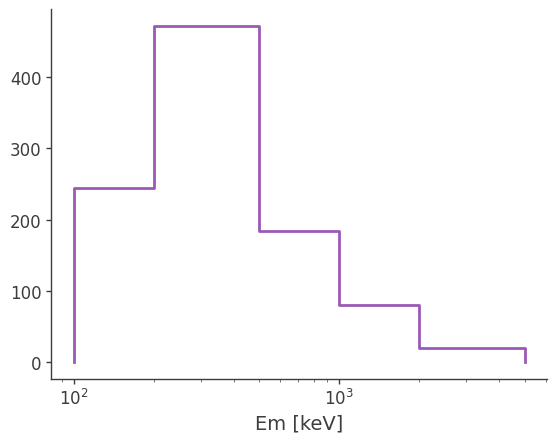

In [26]:
bkg.project('Em').plot()

(<matplotlib.image.AxesImage at 0x7fd09f741c60>, <OrthviewSubplot: >)

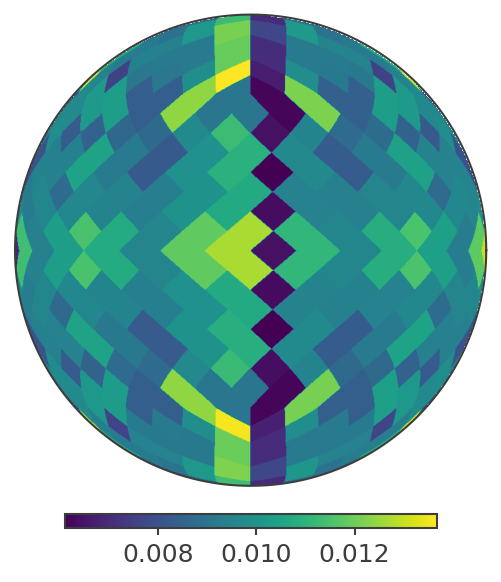

In [27]:
m_bkg = HealpixMap(bkg.slice[{'Em':3, 'Phi':0}].project('PsiChi').todense().contents)

fig = plt.figure(dpi = 150)

ax = fig.add_subplot(projection = 'orthview')

m_bkg.plot(ax)

Note: I actually don't understand what causes the strip in the middle. Maybe it's a beating pattern caused by converting from FISBEL to HEALPix during the creation of the detector response. I plan to generate a detector response using HEALPix directly, and will revisit this then.

## Adding Bkg + Source to get Data

Once we obtain the expected signal, it's easy to add it do the background to simulate how the observed data would look like

In [28]:
data = signal + bkg

If the user wants to simulate multiple sources, just add those to this sum.

This is how it looks:

(<matplotlib.image.AxesImage at 0x7fd09c7945b0>, <OrthviewSubplot: >)

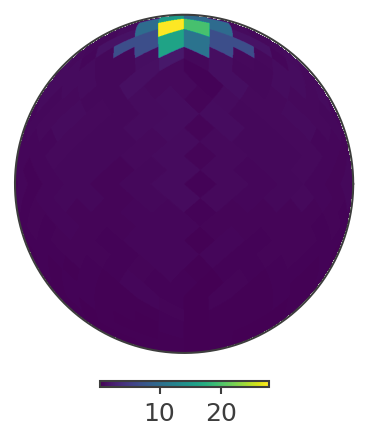

In [29]:
m_data = HealpixMap(data.slice[{'Em':3, 'Phi':0}].project('PsiChi').todense().contents)

fig = plt.figure(dpi = 150)

ax = fig.add_subplot(1,2,1, projection = 'orthview')

m_data.plot(ax)

The final source injector should save the result to disk in the same format as the "Data classes" module, including all the appropiate header information. However, for now you can use directly histpy's `write` method:

In [32]:
data.write("GRBdata.h5")
bkg.write("GRBbkg.h5")
signal.write("GRBsignal.h5")

To load them back, use:

In [33]:
data = Histogram.open("/Users/ckierans/Software/COSItools/COSItools/cosipy/docs/tutorials/GRBdata.h5")
bkg = Histogram.open("/Users/ckierans/Software/COSItools/COSItools/cosipy/docs/tutorials/GRBbkg.h5")
signal = Histogram.open("/Users/ckierans/Software/COSItools/COSItools/cosipy/docs/tutorials/GRBsignal.h5")

## Now reading in the data to make TS Map

In [34]:
tsmap = TSMap()

In [35]:
print(coord.icrs.ra.deg)

306.3669458839138


In [36]:
print(coord.icrs.dec.deg)

7.507101864237928


In [37]:
piv = 1
index = -2

tsmap.link_model_all_plugins(dr=response_path,
                             data=bkg + 3*signal,
                             bkg=bkg,
                             sc_orientation=grbori,
                             piv=piv,
                             index=index,
                             ra = coord.icrs.ra.deg,
                             dec = coord.icrs.dec.deg)

09:00:03 INFO      set the minimizer to minuit                                             ]8;id=523930;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=983643;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

In [10]:
tsmap.ts_fitting()

ra =  0/49   dec =  0/24   position change!


11:12:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=315866;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=16056;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec =  1/24   position change!


11:13:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=261733;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=259386;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec =  2/24   position change!


11:13:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=851395;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=75847;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec =  3/24   position change!


11:13:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=12627;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=567205;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec =  4/24   position change!


11:13:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=894236;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=830159;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec =  5/24   position change!


11:13:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=469658;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=548447;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec =  6/24   position change!


11:13:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=587807;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=926105;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec =  7/24   position change!


11:13:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=950824;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=458278;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec =  8/24   position change!


11:13:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=757914;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=394874;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec =  9/24   position change!


11:13:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=725194;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=670724;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 10/24   position change!


11:13:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=324427;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=841410;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 11/24   position change!


11:13:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=394536;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=23541;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 12/24   position change!


11:13:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=491437;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=745723;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 13/24   position change!


11:13:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=649801;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=603892;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 14/24   position change!


11:13:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=360026;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=403473;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 15/24   position change!


11:14:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=157175;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=679215;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 16/24   position change!


11:14:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=746181;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=361658;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 17/24   position change!


11:14:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=809303;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=373162;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 18/24   position change!


11:14:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=906300;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=359574;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 19/24   position change!


11:14:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=788137;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=856987;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 20/24   position change!


11:14:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=506170;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=479688;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 21/24   position change!


11:14:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=166193;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=74764;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 22/24   position change!


11:14:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=381751;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=462963;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  0/49   dec = 23/24   position change!


11:14:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=882098;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=198842;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  0/24   position change!


11:14:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=477730;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=404289;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  1/24   position change!


11:14:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=489598;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=595005;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  2/24   position change!


11:14:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=891528;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=88436;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  3/24   position change!


11:14:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=755869;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=891751;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  4/24   position change!


11:15:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=152638;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=949405;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  5/24   position change!


11:15:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=754634;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=583059;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  6/24   position change!


11:15:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=138428;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=871525;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  7/24   position change!


11:15:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=461790;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=845300;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  8/24   position change!


11:15:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=424195;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=660066;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec =  9/24   position change!


11:15:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=139127;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=581038;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 10/24   position change!


11:15:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=577973;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=988711;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 11/24   position change!


11:15:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=922063;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=872272;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 12/24   position change!


11:15:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=638258;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=673702;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 13/24   position change!


11:15:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=748152;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=347176;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 14/24   position change!


11:15:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=923028;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=204093;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 15/24   position change!


11:15:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=107414;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=582235;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 16/24   position change!


11:15:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=90513;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=971099;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 17/24   position change!


11:16:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=693897;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=981793;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 18/24   position change!


11:16:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=679620;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=670732;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 19/24   position change!


11:16:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=610418;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=899274;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 20/24   position change!


11:16:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=533905;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=436345;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 21/24   position change!


11:16:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=18282;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=735814;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 22/24   position change!


11:16:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=964342;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=30715;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  1/49   dec = 23/24   position change!


11:16:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=432847;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=742059;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  0/24   position change!


11:16:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=9125;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=131064;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  1/24   position change!


11:16:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=383176;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=749975;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  2/24   position change!


11:16:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=563032;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=107777;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  3/24   position change!


11:16:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=113215;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=349804;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  4/24   position change!


11:16:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=223859;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=356367;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  5/24   position change!


11:16:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=979519;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=867046;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  6/24   position change!


11:16:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=217539;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=382782;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  7/24   position change!


11:17:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=736563;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=3978;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  8/24   position change!


11:17:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=679701;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=104921;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec =  9/24   position change!


11:17:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=496896;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=168270;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 10/24   position change!


11:17:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=143930;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=698663;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 11/24   position change!


11:17:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=887614;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=357946;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 12/24   position change!


11:17:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=882218;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=464989;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 13/24   position change!


11:17:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=883684;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=650281;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 14/24   position change!


11:17:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=687792;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=955264;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 15/24   position change!


11:17:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=43279;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=5599;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 16/24   position change!


11:17:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=11343;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=63765;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 17/24   position change!


11:17:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=823555;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=567122;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 18/24   position change!


11:17:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=52831;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=554117;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 19/24   position change!


11:17:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=155410;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=706725;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 20/24   position change!


11:18:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=620141;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=105544;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 21/24   position change!


11:18:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=104672;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=35938;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 22/24   position change!


11:18:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=758440;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=912277;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  2/49   dec = 23/24   position change!


11:18:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=977321;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=870678;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  0/24   position change!


11:18:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=366794;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=253654;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  1/24   position change!


11:18:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=554347;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=136602;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  2/24   position change!


11:18:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=930645;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=337498;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  3/24   position change!


11:18:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=481872;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=753059;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  4/24   position change!


11:18:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=366304;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=754171;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  5/24   position change!


11:18:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=571983;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=466239;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  6/24   position change!


11:18:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=561718;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=887627;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  7/24   position change!


11:18:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=698350;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=945488;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  8/24   position change!


11:18:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=827923;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=11377;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec =  9/24   position change!


11:19:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=47516;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=612903;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 10/24   position change!


11:19:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=92946;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=522142;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 11/24   position change!


11:19:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=324911;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=377443;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 12/24   position change!


11:19:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=679306;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=892542;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 13/24   position change!


11:19:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=969110;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=142838;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 14/24   position change!


11:19:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=523894;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=813080;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 15/24   position change!


11:19:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=824893;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=106244;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 16/24   position change!


11:19:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=368978;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=484735;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 17/24   position change!


11:19:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=81640;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=248162;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 18/24   position change!


11:19:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=540263;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=557155;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 19/24   position change!


11:19:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=841772;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=681532;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 20/24   position change!


11:19:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=522590;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=555001;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 21/24   position change!


11:19:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=764857;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=72706;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 22/24   position change!


11:19:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=7620;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=358;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  3/49   dec = 23/24   position change!


11:20:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=766889;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=302947;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  0/24   position change!


11:20:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=956799;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=955727;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  1/24   position change!


11:20:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=290058;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=639655;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  2/24   position change!


11:20:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=117432;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=938952;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  3/24   position change!


11:20:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=231021;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=95724;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  4/24   position change!


11:20:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=833534;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=846405;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  5/24   position change!


11:20:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=746779;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=247110;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  6/24   position change!


11:20:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=408215;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=764104;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  7/24   position change!


11:20:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=457593;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=387222;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  8/24   position change!


11:20:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=550587;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=448360;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec =  9/24   position change!


11:20:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=158399;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=706627;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 10/24   position change!


11:20:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=174599;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=73506;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 11/24   position change!


11:20:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=57798;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=705691;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 12/24   position change!


11:21:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=794675;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=410867;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 13/24   position change!


11:21:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=3990;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=959506;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 14/24   position change!


11:21:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=429346;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=521820;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 15/24   position change!


11:21:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=256077;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=458920;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 16/24   position change!


11:21:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=261334;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=234101;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 17/24   position change!


11:21:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=101229;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=695679;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 18/24   position change!


11:21:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=282178;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=318910;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 19/24   position change!


11:21:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=662272;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=293365;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 20/24   position change!


11:21:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=179805;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=610234;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 21/24   position change!


11:21:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=391377;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=296814;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 22/24   position change!


11:21:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=118210;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=988196;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  4/49   dec = 23/24   position change!


11:21:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=681945;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=640713;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  0/24   position change!


11:21:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=580790;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=287661;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  1/24   position change!


11:22:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=221465;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=401563;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  2/24   position change!


11:22:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=666628;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=86594;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  3/24   position change!


11:22:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=514596;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=892966;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  4/24   position change!


11:22:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=128755;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=357925;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  5/24   position change!


11:22:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=796389;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=310518;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  6/24   position change!


11:22:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=772071;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=520957;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  7/24   position change!


11:22:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=45474;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=131321;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  8/24   position change!


11:22:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=581863;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=516377;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec =  9/24   position change!


11:22:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=17009;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=870679;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 10/24   position change!


11:22:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=362442;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=416549;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 11/24   position change!


11:22:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=441590;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=881766;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 12/24   position change!


11:22:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=314000;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=641761;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 13/24   position change!


11:22:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=80833;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=594431;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 14/24   position change!


11:22:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=778284;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=895981;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 15/24   position change!


11:23:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=715919;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=923102;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 16/24   position change!


11:23:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=642175;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=132184;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 17/24   position change!


11:23:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=462574;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=199762;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 18/24   position change!


11:23:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=920169;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=881243;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 19/24   position change!


11:23:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=663889;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=671657;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 20/24   position change!


11:23:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=596422;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=632956;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 21/24   position change!


11:23:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=889849;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=948740;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 22/24   position change!


11:23:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=624442;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=567604;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  5/49   dec = 23/24   position change!


11:23:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=110672;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=968863;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  0/24   position change!


11:23:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=930783;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=1357;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  1/24   position change!


11:23:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=538843;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=761115;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  2/24   position change!


11:23:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=722785;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=185920;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  3/24   position change!


11:23:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=169752;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=538025;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  4/24   position change!


11:24:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=293694;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=18525;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  5/24   position change!


11:24:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=350743;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=513332;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  6/24   position change!


11:24:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=489355;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=84247;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  7/24   position change!


11:24:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=464744;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=137708;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  8/24   position change!


11:24:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=983862;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=284075;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec =  9/24   position change!


11:24:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=95882;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=196717;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 10/24   position change!


11:24:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=926853;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=241074;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 11/24   position change!


11:24:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=525764;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=950166;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 12/24   position change!


11:24:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=577831;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=994222;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 13/24   position change!


11:24:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=844596;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=230944;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 14/24   position change!


11:24:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=755465;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=801249;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 15/24   position change!


11:24:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=152527;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=776430;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 16/24   position change!


11:24:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=315872;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=845564;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 17/24   position change!


11:24:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=589628;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=515728;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 18/24   position change!


11:25:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=489237;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=854138;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 19/24   position change!


11:25:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=372219;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=313663;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 20/24   position change!


11:25:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=637073;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=149481;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 21/24   position change!


11:25:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=847197;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=585935;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 22/24   position change!


11:25:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=754605;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=581857;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  6/49   dec = 23/24   position change!


11:25:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=887024;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=388032;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  0/24   position change!


11:25:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=7784;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=505219;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  1/24   position change!


11:25:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=754270;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=717554;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  2/24   position change!


11:25:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=351620;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=307965;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  3/24   position change!


11:25:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=380892;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=383953;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  4/24   position change!


11:25:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=865789;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=833712;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  5/24   position change!


11:25:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=768518;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=288941;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  6/24   position change!


11:25:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=558016;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=833280;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  7/24   position change!


11:26:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=752671;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=529192;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  8/24   position change!


11:26:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=426877;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=415930;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec =  9/24   position change!


11:26:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=984960;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=522488;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 10/24   position change!


11:26:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=955741;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=264833;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 11/24   position change!


11:26:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=6747;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=832081;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 12/24   position change!


11:26:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=767657;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=351407;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 13/24   position change!


11:26:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=970911;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=695460;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 14/24   position change!


11:26:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=498322;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=826486;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 15/24   position change!


11:26:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=725695;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=631789;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 16/24   position change!


11:26:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=390538;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=259651;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 17/24   position change!


11:26:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=276905;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=73905;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 18/24   position change!


11:26:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=625833;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=875285;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 19/24   position change!


11:26:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=583421;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=327455;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 20/24   position change!


11:26:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=111469;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=304120;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 21/24   position change!


11:27:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=635185;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=430749;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 22/24   position change!


11:27:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=86846;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=176001;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  7/49   dec = 23/24   position change!


11:27:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=727541;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=863405;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  0/24   position change!


11:27:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=163170;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=250440;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  1/24   position change!


11:27:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=911636;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=897714;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  2/24   position change!


11:27:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=905152;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=890795;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  3/24   position change!


11:27:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=402912;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=733070;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  4/24   position change!


11:27:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=952231;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=657108;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  5/24   position change!


11:27:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=798095;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=298301;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  6/24   position change!


11:27:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=381841;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=522739;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  7/24   position change!


11:27:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=479292;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=630867;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  8/24   position change!


11:27:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=895427;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=752444;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec =  9/24   position change!


11:27:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=796156;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=668683;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 10/24   position change!


11:27:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=370109;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=454147;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 11/24   position change!


11:28:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=608144;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=683839;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 12/24   position change!


11:28:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=207143;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=608014;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 13/24   position change!


11:28:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=856646;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=360889;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 14/24   position change!


11:28:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=956446;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=968323;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 15/24   position change!


11:28:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=73716;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=605898;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 16/24   position change!


11:28:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=760665;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=33321;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 17/24   position change!


11:28:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=272734;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=894391;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 18/24   position change!


11:28:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=762199;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=648347;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 19/24   position change!


11:28:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=320520;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=235614;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 20/24   position change!


11:28:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=977817;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=932463;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 21/24   position change!


11:28:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=565625;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=688438;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 22/24   position change!


11:28:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=596505;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=191414;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  8/49   dec = 23/24   position change!


11:28:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=938856;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=201244;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  0/24   position change!


11:29:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=578109;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=621196;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  1/24   position change!


11:29:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=611189;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=617783;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  2/24   position change!


11:29:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=149312;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=939638;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  3/24   position change!


11:29:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=745808;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=517406;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  4/24   position change!


11:29:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=528433;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=456309;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  5/24   position change!


11:29:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=441765;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=103058;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  6/24   position change!


11:29:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=173125;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=891059;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  7/24   position change!


11:29:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=777252;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=67483;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  8/24   position change!


11:29:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=827965;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=382254;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec =  9/24   position change!


11:29:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=97852;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=908459;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 10/24   position change!


11:29:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=487177;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=110358;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 11/24   position change!


11:29:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=883121;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=501736;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 12/24   position change!


11:29:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=438158;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=234903;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 13/24   position change!


11:29:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=278336;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=636347;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 14/24   position change!


11:30:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=856350;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=497770;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 15/24   position change!


11:30:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=829771;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=551540;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 16/24   position change!


11:30:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=269013;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=59967;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 17/24   position change!


11:30:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=641016;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=626456;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 18/24   position change!


11:30:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=749217;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=773249;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 19/24   position change!


11:30:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=785715;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=923196;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 20/24   position change!


11:30:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=777412;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=613870;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 21/24   position change!


11:30:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=809417;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=72550;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 22/24   position change!


11:30:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=578738;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=923385;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra =  9/49   dec = 23/24   position change!


11:30:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=599462;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=385271;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  0/24   position change!


11:30:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=108034;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=799692;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  1/24   position change!


11:30:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=244484;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=318608;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  2/24   position change!


11:30:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=330195;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=27474;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  3/24   position change!


11:31:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=935877;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=476104;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  4/24   position change!


11:31:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=856580;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=926121;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  5/24   position change!


11:31:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=840745;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=144866;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  6/24   position change!


11:31:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=359742;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=330212;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  7/24   position change!


11:31:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=280732;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=496740;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  8/24   position change!


11:31:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=438635;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=662479;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec =  9/24   position change!


11:31:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=771989;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=364549;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 10/24   position change!


11:31:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=94206;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=58083;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 11/24   position change!


11:31:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=85087;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=194430;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 12/24   position change!


11:31:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=882184;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=632019;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 13/24   position change!


11:31:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=283444;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=736692;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 14/24   position change!


11:31:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=416705;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=610367;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 15/24   position change!


11:31:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=671513;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=376836;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 16/24   position change!


11:31:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=776263;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=88584;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 17/24   position change!


11:32:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=862213;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=455994;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 18/24   position change!


11:32:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=241283;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=711477;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 19/24   position change!


11:32:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=587385;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=991244;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 20/24   position change!


11:32:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=564470;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=966201;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 21/24   position change!


11:32:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=223275;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=825806;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 22/24   position change!


11:32:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=773803;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=953652;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 10/49   dec = 23/24   position change!


11:32:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=705198;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=549310;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  0/24   position change!


11:32:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=582493;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=780698;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  1/24   position change!


11:32:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=436171;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=201014;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  2/24   position change!


11:32:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=430334;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=391248;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  3/24   position change!


11:32:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=840005;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=654302;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  4/24   position change!


11:32:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=914272;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=392437;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  5/24   position change!


11:32:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=429088;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=922220;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  6/24   position change!


11:33:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=583007;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=837899;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  7/24   position change!


11:33:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=555007;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=48119;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  8/24   position change!


11:33:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=593680;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=69840;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec =  9/24   position change!


11:33:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=769935;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=370480;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 10/24   position change!


11:33:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=962768;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=548383;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 11/24   position change!


11:33:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=336836;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=878280;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 12/24   position change!


11:33:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=269725;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=115320;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 13/24   position change!


11:33:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=772790;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=496063;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 14/24   position change!


11:33:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=214586;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=442171;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 15/24   position change!


11:33:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=699722;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=451382;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 16/24   position change!


11:33:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=356228;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=810694;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 17/24   position change!


11:33:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=228290;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=577109;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 18/24   position change!


11:33:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=958214;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=61118;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 19/24   position change!


11:33:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=396344;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=289053;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 20/24   position change!


11:34:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=814115;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=700338;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 21/24   position change!


11:34:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=183602;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=394495;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 22/24   position change!


11:34:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=259095;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=874986;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 11/49   dec = 23/24   position change!


11:34:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=142130;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=488330;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  0/24   position change!


11:34:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=274190;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=867438;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  1/24   position change!


11:34:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=632048;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=622768;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  2/24   position change!


11:34:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=382842;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=415464;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  3/24   position change!


11:34:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=816520;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=104763;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  4/24   position change!


11:34:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=159880;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=674619;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  5/24   position change!


11:34:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=560987;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=142045;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  6/24   position change!


11:34:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=258846;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=585967;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  7/24   position change!


11:34:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=76734;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=615143;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  8/24   position change!


11:34:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=981369;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=721177;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec =  9/24   position change!


11:34:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=697000;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=423205;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 10/24   position change!


11:35:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=310286;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=550351;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 11/24   position change!


11:35:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=454803;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=514032;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 12/24   position change!


11:35:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=504958;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=828164;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 13/24   position change!


11:35:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=323311;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=819740;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 14/24   position change!


11:35:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=803890;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=743366;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 15/24   position change!


11:35:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=133889;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=66709;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 16/24   position change!


11:35:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=547736;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=729655;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 17/24   position change!


11:35:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=711909;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=809688;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 18/24   position change!


11:35:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=416065;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=420298;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 19/24   position change!


11:35:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=679015;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=247697;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 20/24   position change!


11:35:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=452415;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=444315;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 21/24   position change!


11:35:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=392448;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=161804;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 22/24   position change!


11:35:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=969382;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=983740;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 12/49   dec = 23/24   position change!


11:35:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=641448;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=12469;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  0/24   position change!


11:36:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=819495;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=800008;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  1/24   position change!


11:36:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=310680;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=748021;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  2/24   position change!


11:36:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=27419;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=769198;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  3/24   position change!


11:36:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=739715;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=272163;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  4/24   position change!


11:36:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=353387;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=979438;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  5/24   position change!


11:36:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=156811;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=610017;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  6/24   position change!


11:36:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=234962;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=856663;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  7/24   position change!


11:36:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=586834;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=644191;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  8/24   position change!


11:36:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=246660;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=199725;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec =  9/24   position change!


11:36:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=381152;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=837360;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 10/24   position change!


11:36:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=170276;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=703685;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 11/24   position change!


11:36:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=47795;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=857238;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 12/24   position change!


11:36:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=47742;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=895446;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 13/24   position change!


11:36:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=571437;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=408234;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 14/24   position change!


11:37:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=265135;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=500013;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 15/24   position change!


11:37:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=438940;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=289261;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 16/24   position change!


11:37:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=604193;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=238824;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 17/24   position change!


11:37:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=40608;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=939446;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 18/24   position change!


11:37:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=833762;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=360598;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 19/24   position change!


11:37:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=384888;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=536987;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 20/24   position change!


11:37:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=646123;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=299128;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 21/24   position change!


11:37:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=380098;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=361727;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 22/24   position change!


11:37:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=751506;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=418545;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 13/49   dec = 23/24   position change!


11:37:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=93914;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=148596;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  0/24   position change!


11:37:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=999252;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=689377;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  1/24   position change!


11:37:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=863903;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=792379;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  2/24   position change!


11:37:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=590422;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=29840;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  3/24   position change!


11:37:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=564043;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=360919;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  4/24   position change!


11:38:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=362265;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=797890;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  5/24   position change!


11:38:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=555411;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=942897;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  6/24   position change!


11:38:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=144872;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=988260;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  7/24   position change!


11:38:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=719340;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=157771;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  8/24   position change!


11:38:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=520938;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=306612;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec =  9/24   position change!


11:38:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=463444;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=35863;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 10/24   position change!


11:38:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=316631;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=230040;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 11/24   position change!


11:38:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=863055;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=27881;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 12/24   position change!


11:38:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=111562;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=426312;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 13/24   position change!


11:38:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=625644;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=643925;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 14/24   position change!


11:38:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=899718;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=802329;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 15/24   position change!


11:38:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=653353;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=725491;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 16/24   position change!


11:38:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=962842;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=155756;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 17/24   position change!


11:39:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=514649;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=527587;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 18/24   position change!


11:39:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=881426;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=445302;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 19/24   position change!


11:39:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=725698;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=384334;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 20/24   position change!


11:39:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=868518;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=499185;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 21/24   position change!


11:39:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=642908;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=399309;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 22/24   position change!


11:39:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=564567;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=870084;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 14/49   dec = 23/24   position change!


11:39:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=482599;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=548154;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  0/24   position change!


11:39:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=492444;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=670116;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  1/24   position change!


11:39:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=5865;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=244020;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  2/24   position change!


11:39:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=306050;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=904245;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  3/24   position change!


11:39:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=297996;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=821619;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  4/24   position change!


11:39:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=443677;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=27902;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  5/24   position change!


11:39:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=16201;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=178172;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  6/24   position change!


11:39:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=54244;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=412965;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  7/24   position change!


11:40:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=159485;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=904258;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  8/24   position change!


11:40:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=278332;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=431697;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec =  9/24   position change!


11:40:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=103549;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=59737;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 10/24   position change!


11:40:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=650857;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=553462;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 11/24   position change!


11:40:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=956069;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=110097;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 12/24   position change!


11:40:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=42869;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=490905;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 13/24   position change!


11:40:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=998103;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=899534;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 14/24   position change!


11:40:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=262960;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=699822;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 15/24   position change!


11:40:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=945840;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=416463;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 16/24   position change!


11:40:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=86972;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=373718;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 17/24   position change!


11:40:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=712082;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=819736;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 18/24   position change!


11:40:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=602225;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=602560;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 19/24   position change!


11:40:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=561055;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=397576;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 20/24   position change!


11:40:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=945548;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=681537;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 21/24   position change!


11:41:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=785953;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=732425;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 22/24   position change!


11:41:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=282204;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=662684;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 15/49   dec = 23/24   position change!


11:41:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=203533;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=953186;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  0/24   position change!


11:41:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=960631;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=958066;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  1/24   position change!


11:41:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=544962;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=495300;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  2/24   position change!


11:41:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=939285;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=432461;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  3/24   position change!


11:41:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=361110;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=248360;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  4/24   position change!


11:41:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=771306;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=726817;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  5/24   position change!


11:41:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=903005;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=483337;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  6/24   position change!


11:41:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=562357;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=741618;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  7/24   position change!


11:41:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=336344;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=564116;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  8/24   position change!


11:41:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=331740;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=567105;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec =  9/24   position change!


11:41:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=879827;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=636511;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 10/24   position change!


11:41:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=440586;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=205748;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 11/24   position change!


11:42:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=974178;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=495044;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 12/24   position change!


11:42:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=585212;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=854154;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 13/24   position change!


11:42:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=880607;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=978804;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 14/24   position change!


11:42:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=916968;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=983351;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 15/24   position change!


11:42:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=88126;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=93196;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 16/24   position change!


11:42:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=902197;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=448047;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 17/24   position change!


11:42:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=974458;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=65565;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 18/24   position change!


11:42:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=96636;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=338365;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 19/24   position change!


11:42:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=155628;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=24929;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 20/24   position change!


11:42:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=264282;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=200349;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 21/24   position change!


11:42:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=953673;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=229956;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 22/24   position change!


11:42:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=846020;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=328063;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 16/49   dec = 23/24   position change!


11:42:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=292676;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=301659;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  0/24   position change!


11:42:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=806704;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=889146;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  1/24   position change!


11:43:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=910097;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=117553;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  2/24   position change!


11:43:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=342704;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=741448;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  3/24   position change!


11:43:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=716496;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=686786;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  4/24   position change!


11:43:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=122142;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=432118;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  5/24   position change!


11:43:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=97999;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=743082;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  6/24   position change!


11:43:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=459615;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=349990;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  7/24   position change!


11:43:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=507158;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=89735;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  8/24   position change!


11:43:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=288253;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=350318;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec =  9/24   position change!


11:43:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=115395;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=798528;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 10/24   position change!


11:43:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=983039;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=773529;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 11/24   position change!


11:43:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=292057;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=158008;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 12/24   position change!


11:43:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=553887;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=190243;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 13/24   position change!


11:43:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=107375;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=320634;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 14/24   position change!


11:43:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=301551;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=772707;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 15/24   position change!


11:43:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=828627;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=131785;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 16/24   position change!


11:44:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=85645;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=125726;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 17/24   position change!


11:44:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=229033;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=64921;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 18/24   position change!


11:44:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=859332;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=723701;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 19/24   position change!


11:44:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=525448;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=45185;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 20/24   position change!


11:44:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=583631;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=639813;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 21/24   position change!


11:44:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=60663;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=288616;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 22/24   position change!


11:44:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=988873;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=672237;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 17/49   dec = 23/24   position change!


11:44:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=30583;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=33148;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  0/24   position change!


11:44:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=936449;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=714998;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  1/24   position change!


11:44:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=817846;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=834551;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  2/24   position change!


11:44:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=952118;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=182259;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  3/24   position change!


11:44:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=783116;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=877040;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  4/24   position change!


11:44:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=340690;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=145837;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  5/24   position change!


11:45:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=815626;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=133437;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  6/24   position change!


11:45:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=363573;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=61693;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  7/24   position change!


11:45:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=951148;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=106859;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  8/24   position change!


11:45:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=327291;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=993894;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec =  9/24   position change!


11:45:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=287400;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=975513;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 10/24   position change!


11:45:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=90723;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=120385;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 11/24   position change!


11:45:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=865281;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=240639;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 12/24   position change!


11:45:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=712303;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=305822;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 13/24   position change!


11:45:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=289020;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=931567;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 14/24   position change!


11:45:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=484312;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=128383;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 15/24   position change!


11:45:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=759937;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=878451;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 16/24   position change!


11:45:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=835212;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=210057;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 17/24   position change!


11:45:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=914845;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=714390;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 18/24   position change!


11:45:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=890354;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=773898;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 19/24   position change!


11:46:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=315343;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=911908;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 20/24   position change!


11:46:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=635230;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=466015;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 21/24   position change!


11:46:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=476091;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=765043;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 22/24   position change!


11:46:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=732965;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=817525;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 18/49   dec = 23/24   position change!


11:46:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=317951;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=992695;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  0/24   position change!


11:46:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=421197;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=337821;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  1/24   position change!


11:46:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=20451;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=320982;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  2/24   position change!


11:46:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=350819;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=455978;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  3/24   position change!


11:46:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=452808;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=88582;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  4/24   position change!


11:46:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=306195;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=525631;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  5/24   position change!


11:46:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=750153;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=36522;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  6/24   position change!


11:46:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=994285;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=888383;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  7/24   position change!


11:46:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=121050;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=541213;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  8/24   position change!


11:46:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=596858;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=931291;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec =  9/24   position change!


11:47:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=686236;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=107373;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 10/24   position change!


11:47:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=645589;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=863367;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 11/24   position change!


11:47:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=327168;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=134040;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 12/24   position change!


11:47:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=153295;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=981589;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 13/24   position change!


11:47:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=379170;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=123054;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 14/24   position change!


11:47:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=254500;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=110243;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 15/24   position change!


11:47:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=431331;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=327600;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 16/24   position change!


11:47:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=668014;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=756487;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 17/24   position change!


11:47:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=198715;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=717039;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 18/24   position change!


11:47:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=827429;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=770486;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 19/24   position change!


11:47:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=216693;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=489862;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 20/24   position change!


11:47:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=482331;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=938632;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 21/24   position change!


11:47:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=218148;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=143265;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 22/24   position change!


11:48:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=508187;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=549604;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 19/49   dec = 23/24   position change!


11:48:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=40355;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=964860;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  0/24   position change!


11:48:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=885038;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=153401;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  1/24   position change!


11:48:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=389980;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=517992;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  2/24   position change!


11:48:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=80653;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=956687;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  3/24   position change!


11:48:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=1835;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=939045;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  4/24   position change!


11:48:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=784616;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=19545;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  5/24   position change!


11:48:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=652856;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=667552;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  6/24   position change!


11:48:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=879036;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=530297;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  7/24   position change!


11:48:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=306884;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=825720;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  8/24   position change!


11:48:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=157310;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=394926;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec =  9/24   position change!


11:48:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=40793;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=257977;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 10/24   position change!


11:48:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=887382;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=759605;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 11/24   position change!


11:49:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=986964;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=255113;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 12/24   position change!


11:49:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=996753;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=71105;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 13/24   position change!


11:49:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=669912;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=560237;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 14/24   position change!


11:49:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=729118;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=148507;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 15/24   position change!


11:49:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=781546;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=243356;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 16/24   position change!


11:49:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=115379;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=662962;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 17/24   position change!


11:49:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=815994;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=473619;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 18/24   position change!


11:49:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=582451;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=338416;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 19/24   position change!


11:49:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=307978;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=606090;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 20/24   position change!


11:49:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=867033;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=390232;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 21/24   position change!


11:49:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=855830;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=988370;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 22/24   position change!


11:49:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=985952;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=991501;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 20/49   dec = 23/24   position change!


11:49:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=57207;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=222299;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  0/24   position change!


11:49:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=54989;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=903815;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  1/24   position change!


11:50:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=894573;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=107686;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  2/24   position change!


11:50:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=955628;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=726369;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  3/24   position change!


11:50:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=212415;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=249090;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  4/24   position change!


11:50:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=24363;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=62183;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  5/24   position change!


11:50:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=83532;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=526345;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  6/24   position change!


11:50:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=964618;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=440655;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  7/24   position change!


11:50:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=832870;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=540702;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  8/24   position change!


11:50:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=358719;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=934818;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec =  9/24   position change!


11:50:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=650553;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=556019;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 10/24   position change!


11:50:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=131974;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=53634;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 11/24   position change!


11:50:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=266886;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=914201;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 12/24   position change!


11:50:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=570216;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=950554;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 13/24   position change!


11:50:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=260615;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=507693;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 14/24   position change!


11:50:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=543872;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=664278;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 15/24   position change!


11:51:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=2454;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=741965;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 16/24   position change!


11:51:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=182917;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=205928;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 17/24   position change!


11:51:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=104378;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=23922;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 18/24   position change!


11:51:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=15092;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=778171;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 19/24   position change!


11:51:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=476919;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=850414;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 20/24   position change!


11:51:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=408119;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=393961;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 21/24   position change!


11:51:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=573588;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=47396;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 22/24   position change!


11:51:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=246221;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=899466;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 21/49   dec = 23/24   position change!


11:51:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=333698;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=356568;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  0/24   position change!


11:51:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=727230;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=245732;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  1/24   position change!


11:51:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=127446;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=271697;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  2/24   position change!


11:51:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=775311;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=364148;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  3/24   position change!


11:51:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=153965;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=678806;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  4/24   position change!


11:51:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=704447;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=64877;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  5/24   position change!


11:52:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=882982;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=868917;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  6/24   position change!


11:52:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=289826;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=605704;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  7/24   position change!


11:52:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=148547;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=190546;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  8/24   position change!


11:52:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=899267;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=263672;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec =  9/24   position change!


11:52:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=704321;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=265139;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 10/24   position change!


11:52:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=626018;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=673039;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 11/24   position change!


11:52:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=193560;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=718819;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 12/24   position change!


11:52:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=733542;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=992366;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 13/24   position change!


11:52:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=319354;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=438139;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 14/24   position change!


11:52:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=7559;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=73471;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 15/24   position change!


11:52:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=950360;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=298219;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 16/24   position change!


11:52:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=836245;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=79275;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 17/24   position change!


11:52:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=940839;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=91928;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 18/24   position change!


11:52:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=704815;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=58876;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 19/24   position change!


11:52:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=2269;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=946835;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 20/24   position change!


11:53:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=739397;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=60911;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 21/24   position change!


11:53:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=985672;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=851458;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 22/24   position change!


11:53:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=231989;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=197946;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 22/49   dec = 23/24   position change!


11:53:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=945810;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=61695;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  0/24   position change!


11:53:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=623899;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=278703;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  1/24   position change!


11:53:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=964307;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=155018;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  2/24   position change!


11:53:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=730305;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=125067;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  3/24   position change!


11:53:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=683733;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=240478;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  4/24   position change!


11:53:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=389104;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=893463;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  5/24   position change!


11:53:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=428551;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=974609;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  6/24   position change!


11:53:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=549744;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=754344;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  7/24   position change!


11:53:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=795073;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=894015;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  8/24   position change!


11:53:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=649562;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=346799;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec =  9/24   position change!


11:53:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=387160;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=250436;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 10/24   position change!


11:54:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=818872;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=631821;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 11/24   position change!


11:54:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=903636;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=312296;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 12/24   position change!


11:54:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=526272;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=311576;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 13/24   position change!


11:54:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=390829;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=955764;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 14/24   position change!


11:54:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=268964;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=488479;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 15/24   position change!


11:54:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=194870;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=969918;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 16/24   position change!


11:54:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=382237;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=991803;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 17/24   position change!


11:54:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=733664;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=662517;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 18/24   position change!


11:54:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=784811;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=531822;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 19/24   position change!


11:54:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=190600;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=271223;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 20/24   position change!


11:54:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=334425;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=369559;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 21/24   position change!


11:54:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=914120;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=6179;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 22/24   position change!


11:54:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=239827;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=978219;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 23/49   dec = 23/24   position change!


11:54:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=647438;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=980652;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  0/24   position change!


11:55:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=332212;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=124897;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  1/24   position change!


11:55:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=905171;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=571518;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  2/24   position change!


11:55:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=633469;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=171987;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  3/24   position change!


11:55:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=516798;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=953837;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  4/24   position change!


11:55:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=939559;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=757049;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  5/24   position change!


11:55:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=942603;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=571235;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  6/24   position change!


11:55:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=988170;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=282345;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  7/24   position change!


11:55:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=877417;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=126565;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  8/24   position change!


11:55:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=40117;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=737417;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec =  9/24   position change!


11:55:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=825516;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=758112;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 10/24   position change!


11:55:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=756767;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=429677;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 11/24   position change!


11:55:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=910362;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=29261;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 12/24   position change!


11:55:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=135193;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=990940;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 13/24   position change!


11:55:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=52381;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=853823;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 14/24   position change!


11:56:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=137586;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=309629;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 15/24   position change!


11:56:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=616240;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=981949;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 16/24   position change!


11:56:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=885944;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=190924;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 17/24   position change!


11:56:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=674244;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=83387;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 18/24   position change!


11:56:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=27825;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=702328;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 19/24   position change!


11:56:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=401048;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=956551;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 20/24   position change!


11:56:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=641485;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=237599;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 21/24   position change!


11:56:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=39425;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=387723;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 22/24   position change!


11:56:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=293704;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=987821;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 24/49   dec = 23/24   position change!


11:56:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=497614;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=572455;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  0/24   position change!


11:56:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=716622;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=382745;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  1/24   position change!


11:56:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=699391;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=308053;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  2/24   position change!


11:56:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=206087;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=412735;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  3/24   position change!


11:56:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=592926;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=370238;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  4/24   position change!


11:57:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=909831;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=39533;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  5/24   position change!


11:57:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=741746;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=145808;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  6/24   position change!


11:57:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=489642;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=945091;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  7/24   position change!


11:57:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=486522;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=700243;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  8/24   position change!


11:57:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=923037;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=605655;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec =  9/24   position change!


11:57:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=482843;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=577943;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 10/24   position change!


11:57:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=872814;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=304486;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 11/24   position change!


11:57:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=343161;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=242310;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 12/24   position change!


11:57:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=551082;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=643623;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 13/24   position change!


11:57:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=919899;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=350975;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 14/24   position change!


11:57:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=207548;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=551457;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 15/24   position change!


11:57:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=248238;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=747068;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 16/24   position change!


11:57:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=577845;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=38718;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 17/24   position change!


11:57:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=196597;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=825335;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 18/24   position change!


11:58:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=247595;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=374498;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 19/24   position change!


11:58:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=370642;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=697199;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 20/24   position change!


11:58:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=700854;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=877452;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 21/24   position change!


11:58:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=674552;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=21490;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 22/24   position change!


11:58:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=530851;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=828654;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 25/49   dec = 23/24   position change!


11:58:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=776975;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=254430;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  0/24   position change!


11:58:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=120125;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=774098;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  1/24   position change!


11:58:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=963830;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=420886;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  2/24   position change!


11:58:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=687163;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=605770;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  3/24   position change!


11:58:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=489383;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=544150;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  4/24   position change!


11:58:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=306231;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=852685;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  5/24   position change!


11:58:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=69334;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=578649;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  6/24   position change!


11:58:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=908960;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=439599;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  7/24   position change!


11:58:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=899873;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=282312;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  8/24   position change!


11:59:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=878804;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=161632;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec =  9/24   position change!


11:59:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=200562;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=454694;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 10/24   position change!


11:59:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=245253;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=519908;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 11/24   position change!


11:59:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=279319;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=290788;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 12/24   position change!


11:59:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=342216;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=837131;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 13/24   position change!


11:59:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=131968;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=848105;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 14/24   position change!


11:59:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=44812;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=153972;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 15/24   position change!


11:59:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=162946;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=704110;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 16/24   position change!


11:59:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=919734;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=198306;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 17/24   position change!


11:59:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=334731;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=638695;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 18/24   position change!


11:59:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=708873;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=44167;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 19/24   position change!


11:59:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=714776;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=464589;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 20/24   position change!


11:59:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=774051;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=499113;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 21/24   position change!


11:59:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=479306;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=345300;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 22/24   position change!


12:00:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=740724;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=628;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 26/49   dec = 23/24   position change!


12:00:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=375931;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=989420;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  0/24   position change!


12:00:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=36966;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=777976;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  1/24   position change!


12:00:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=95628;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=938285;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  2/24   position change!


12:00:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=891877;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=891714;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  3/24   position change!


12:00:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=736123;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=300740;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  4/24   position change!


12:00:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=535023;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=62042;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  5/24   position change!


12:00:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=327496;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=117078;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  6/24   position change!


12:00:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=524064;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=442490;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  7/24   position change!


12:00:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=654137;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=875844;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  8/24   position change!


12:00:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=106843;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=768730;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec =  9/24   position change!


12:00:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=340496;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=243124;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 10/24   position change!


12:00:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=155644;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=962218;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 11/24   position change!


12:01:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=597281;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=146961;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 12/24   position change!


12:01:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=206239;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=966395;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 13/24   position change!


12:01:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=816795;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=75675;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 14/24   position change!


12:01:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=203485;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=34291;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 15/24   position change!


12:01:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=682442;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=997882;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 16/24   position change!


12:01:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=936859;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=806840;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 17/24   position change!


12:01:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=806477;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=935121;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 18/24   position change!


12:01:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=807040;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=758564;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 19/24   position change!


12:01:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=816140;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=988994;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 20/24   position change!


12:01:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=632481;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=231696;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 21/24   position change!


12:01:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=429576;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=315400;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 22/24   position change!


12:01:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=841302;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=176401;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 27/49   dec = 23/24   position change!


12:01:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=242236;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=359253;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  0/24   position change!


12:01:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=116442;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=857527;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  1/24   position change!


12:02:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=691790;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=840580;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  2/24   position change!


12:02:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=220563;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=630726;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  3/24   position change!


12:02:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=591381;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=793626;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  4/24   position change!


12:02:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=502948;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=716377;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  5/24   position change!


12:02:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=775027;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=765666;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  6/24   position change!


12:02:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=731285;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=940335;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  7/24   position change!


12:02:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=288682;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=603989;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  8/24   position change!


12:02:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=205685;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=740199;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec =  9/24   position change!


12:02:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=677396;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=437374;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 10/24   position change!


12:02:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=808936;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=605130;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 11/24   position change!


12:02:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=651100;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=387877;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 12/24   position change!


12:02:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=843714;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=61617;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 13/24   position change!


12:02:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=561081;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=263005;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 14/24   position change!


12:03:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=216959;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=569626;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 15/24   position change!


12:03:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=601465;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=127693;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 16/24   position change!


12:03:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=965707;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=760694;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 17/24   position change!


12:03:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=682731;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=367102;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 18/24   position change!


12:03:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=553033;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=161869;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 19/24   position change!


12:03:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=770437;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=534378;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 20/24   position change!


12:03:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=208915;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=661085;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 21/24   position change!


12:03:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=619837;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=374724;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 22/24   position change!


12:03:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=761539;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=449745;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 28/49   dec = 23/24   position change!


12:03:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=837744;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=126993;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  0/24   position change!


12:03:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=724268;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=907227;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  1/24   position change!


12:03:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=318226;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=912724;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  2/24   position change!


12:04:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=976578;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=617509;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  3/24   position change!


12:04:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=752469;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=519808;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  4/24   position change!


12:04:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=304929;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=197078;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  5/24   position change!


12:04:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=228137;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=494527;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  6/24   position change!


12:04:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=227040;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=456768;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  7/24   position change!


12:04:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=242329;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=806263;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  8/24   position change!


12:04:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=399224;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=65274;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec =  9/24   position change!


12:04:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=713710;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=111105;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 10/24   position change!


12:04:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=432879;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=134966;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 11/24   position change!


12:05:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=962633;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=770073;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 12/24   position change!


12:05:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=778379;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=922741;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 13/24   position change!


12:05:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=292312;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=537087;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 14/24   position change!


12:05:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=644526;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=315623;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 15/24   position change!


12:05:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=697616;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=943057;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 16/24   position change!


12:05:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=441727;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=621137;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 17/24   position change!


12:05:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=32574;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=231265;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 18/24   position change!


12:05:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=902915;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=398616;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 19/24   position change!


12:05:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=504182;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=737663;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 20/24   position change!


12:05:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=739995;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=117694;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 21/24   position change!


12:05:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=161699;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=664288;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 22/24   position change!


12:05:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=788364;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=301664;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 29/49   dec = 23/24   position change!


12:06:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=375223;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=61861;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  0/24   position change!


12:06:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=75973;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=949555;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  1/24   position change!


12:06:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=987396;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=816709;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  2/24   position change!


12:06:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=479898;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=52003;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  3/24   position change!


12:06:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=446823;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=339428;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  4/24   position change!


12:06:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=868361;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=68201;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  5/24   position change!


12:06:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=226021;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=180954;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  6/24   position change!


12:06:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=780494;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=62968;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  7/24   position change!


12:06:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=30070;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=217931;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  8/24   position change!


12:06:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=883294;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=423;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec =  9/24   position change!


12:06:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=890257;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=923638;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 10/24   position change!


12:06:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=987750;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=768038;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 11/24   position change!


12:06:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=774253;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=823933;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 12/24   position change!


12:06:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=171654;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=777174;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 13/24   position change!


12:07:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=313396;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=619832;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 14/24   position change!


12:07:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=608042;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=459045;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 15/24   position change!


12:07:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=215590;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=894663;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 16/24   position change!


12:07:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=344942;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=271049;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 17/24   position change!


12:07:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=180370;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=784622;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 18/24   position change!


12:07:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=794235;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=451106;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 19/24   position change!


12:07:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=253136;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=567191;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 20/24   position change!


12:07:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=660055;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=690218;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 21/24   position change!


12:07:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=424421;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=600113;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 22/24   position change!


12:07:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=282071;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=432362;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 30/49   dec = 23/24   position change!


12:07:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=485715;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=687516;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  0/24   position change!


12:07:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=318293;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=6727;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  1/24   position change!


12:07:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=706811;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=789214;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  2/24   position change!


12:07:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=339481;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=816390;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  3/24   position change!


12:07:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=753207;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=175586;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  4/24   position change!


12:08:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=187020;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=690649;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  5/24   position change!


12:08:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=906007;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=483099;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  6/24   position change!


12:08:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=669182;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=691305;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  7/24   position change!


12:08:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=766840;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=593591;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  8/24   position change!


12:08:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=174833;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=991506;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec =  9/24   position change!


12:08:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=798945;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=50826;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 10/24   position change!


12:10:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=535099;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=115912;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 11/24   position change!


12:10:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=790994;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=10116;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 12/24   position change!


12:10:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=532557;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=111707;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 13/24   position change!


12:10:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=430636;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=375555;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 14/24   position change!


12:10:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=919378;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=59826;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 15/24   position change!


12:10:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=53570;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=425166;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 16/24   position change!


12:10:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=130635;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=51140;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 17/24   position change!


12:10:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=840428;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=721487;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 18/24   position change!


12:10:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=694444;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=702690;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 19/24   position change!


12:10:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=572989;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=551028;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 20/24   position change!


12:10:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=182794;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=703501;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 21/24   position change!


12:11:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=221707;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=165172;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 22/24   position change!


12:11:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=855531;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=908919;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 31/49   dec = 23/24   position change!


12:11:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=529563;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=699384;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  0/24   position change!


12:11:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=56507;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=542517;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  1/24   position change!


12:11:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=95472;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=444268;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  2/24   position change!


12:11:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=615286;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=14908;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  3/24   position change!


12:11:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=435943;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=291855;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  4/24   position change!


12:11:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=98515;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=117722;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  5/24   position change!


12:11:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=187938;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=954954;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  6/24   position change!


12:11:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=781252;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=553362;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  7/24   position change!


12:11:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=822541;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=884622;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  8/24   position change!


12:11:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=721074;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=306741;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec =  9/24   position change!


12:11:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=382602;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=289501;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 10/24   position change!


12:12:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=430188;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=126464;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 11/24   position change!


12:12:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=926311;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=6094;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 12/24   position change!


12:12:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=702074;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=966748;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 13/24   position change!


12:12:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=124357;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=459576;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 14/24   position change!


12:12:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=81219;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=669206;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 15/24   position change!


12:12:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=779930;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=867410;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 16/24   position change!


12:12:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=898344;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=843200;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 17/24   position change!


12:12:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=595245;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=352919;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 18/24   position change!


12:12:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=520328;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=169535;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 19/24   position change!


12:12:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=564986;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=343838;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 20/24   position change!


12:12:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=740079;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=403084;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 21/24   position change!


12:12:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=700806;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=214150;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 22/24   position change!


12:12:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=144872;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=839509;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 32/49   dec = 23/24   position change!


12:13:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=20675;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=381742;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  0/24   position change!


12:13:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=960419;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=665489;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  1/24   position change!


12:13:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=742677;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=692906;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  2/24   position change!


12:13:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=251934;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=663996;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  3/24   position change!


12:13:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=915543;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=787263;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  4/24   position change!


12:13:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=975239;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=166004;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  5/24   position change!


12:13:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=902479;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=636617;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  6/24   position change!


12:13:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=536234;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=25002;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  7/24   position change!


12:13:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=584721;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=249388;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  8/24   position change!


12:13:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=229686;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=15228;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec =  9/24   position change!


12:13:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=421776;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=489151;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 10/24   position change!


12:13:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=416998;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=473215;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 11/24   position change!


12:13:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=80145;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=246044;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 12/24   position change!


12:13:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=168156;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=522591;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 13/24   position change!


12:14:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=652636;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=606402;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 14/24   position change!


12:14:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=496387;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=864471;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 15/24   position change!


12:14:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=1004;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=821969;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 16/24   position change!


12:14:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=119282;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=864396;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 17/24   position change!


12:14:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=260862;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=355600;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 18/24   position change!


12:14:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=16525;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=146237;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 19/24   position change!


12:14:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=202418;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=102992;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 20/24   position change!


12:14:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=392002;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=359488;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 21/24   position change!


12:14:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=488445;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=362512;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 22/24   position change!


12:14:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=906598;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=860544;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 33/49   dec = 23/24   position change!


12:14:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=453721;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=846924;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  0/24   position change!


12:14:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=226481;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=14056;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  1/24   position change!


12:14:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=59461;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=478208;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  2/24   position change!


12:15:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=626424;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=512726;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  3/24   position change!


12:15:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=891647;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=270284;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  4/24   position change!


12:15:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=729460;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=1930;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  5/24   position change!


12:15:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=531102;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=167908;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  6/24   position change!


12:15:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=245473;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=228892;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  7/24   position change!


12:15:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=458909;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=616870;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  8/24   position change!


12:15:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=208392;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=528940;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec =  9/24   position change!


12:15:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=794016;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=305313;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 10/24   position change!


12:15:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=787173;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=414624;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 11/24   position change!


12:15:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=801410;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=290814;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 12/24   position change!


12:15:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=910292;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=249;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 13/24   position change!


12:15:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=509656;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=900644;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 14/24   position change!


12:15:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=584034;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=918115;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 15/24   position change!


12:15:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=371575;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=51782;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 16/24   position change!


12:16:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=70500;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=339724;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 17/24   position change!


12:16:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=144229;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=270023;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 18/24   position change!


12:16:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=359244;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=894615;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 19/24   position change!


12:16:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=711303;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=496401;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 20/24   position change!


12:16:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=808537;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=755395;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 21/24   position change!


12:16:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=319633;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=716473;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 22/24   position change!


12:16:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=844698;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=4673;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 34/49   dec = 23/24   position change!


12:16:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=39570;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=978558;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  0/24   position change!


12:16:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=992697;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=761738;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  1/24   position change!


12:16:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=525022;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=810822;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  2/24   position change!


12:16:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=411497;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=568230;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  3/24   position change!


12:16:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=517202;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=515603;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  4/24   position change!


12:16:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=352583;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=144487;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  5/24   position change!


12:16:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=552237;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=530633;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  6/24   position change!


12:16:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=633132;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=187956;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  7/24   position change!


12:17:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=51873;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=136327;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  8/24   position change!


12:17:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=867632;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=917447;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec =  9/24   position change!


12:17:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=669996;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=58378;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 10/24   position change!


12:17:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=278901;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=147181;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 11/24   position change!


12:17:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=387692;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=511698;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 12/24   position change!


12:17:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=55659;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=76592;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 13/24   position change!


12:17:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=33533;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=555390;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 14/24   position change!


12:17:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=351405;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=94931;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 15/24   position change!


12:17:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=906468;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=881583;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 16/24   position change!


12:17:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=176846;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=660897;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 17/24   position change!


12:17:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=994298;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=945333;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 18/24   position change!


12:17:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=135275;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=207679;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 19/24   position change!


12:17:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=958738;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=685540;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 20/24   position change!


12:18:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=230489;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=389883;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 21/24   position change!


12:18:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=713793;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=142069;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 22/24   position change!


12:18:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=94575;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=766393;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 35/49   dec = 23/24   position change!


12:18:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=6473;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=630175;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  0/24   position change!


12:18:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=705745;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=660103;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  1/24   position change!


12:18:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=919712;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=104568;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  2/24   position change!


12:18:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=105022;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=402873;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  3/24   position change!


12:18:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=692243;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=802327;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  4/24   position change!


12:18:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=941733;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=325261;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  5/24   position change!


12:18:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=26900;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=673265;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  6/24   position change!


12:18:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=667813;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=623609;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  7/24   position change!


12:18:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=747374;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=521723;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  8/24   position change!


12:18:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=972716;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=612680;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec =  9/24   position change!


12:18:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=590133;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=712400;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 10/24   position change!


12:19:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=712114;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=542023;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 11/24   position change!


12:19:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=997848;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=494030;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 12/24   position change!


12:19:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=500585;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=340452;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 13/24   position change!


12:19:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=593176;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=811342;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 14/24   position change!


12:19:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=246231;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=33228;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 15/24   position change!


12:19:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=525046;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=725474;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 16/24   position change!


12:19:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=416051;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=47729;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 17/24   position change!


12:19:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=665326;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=695241;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 18/24   position change!


12:19:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=335233;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=902806;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 19/24   position change!


12:19:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=970611;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=724780;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 20/24   position change!


12:19:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=893769;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=79274;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 21/24   position change!


12:19:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=647832;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=368769;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 22/24   position change!


12:19:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=297282;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=203944;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 36/49   dec = 23/24   position change!


12:19:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=441630;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=278694;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  0/24   position change!


12:20:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=834148;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=783018;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  1/24   position change!


12:20:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=462411;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=558064;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  2/24   position change!


12:20:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=167961;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=147463;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  3/24   position change!


12:20:16 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=384802;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=129324;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  4/24   position change!


12:20:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=927298;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=737087;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  5/24   position change!


12:20:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=744270;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=279972;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  6/24   position change!


12:20:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=564444;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=67655;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  7/24   position change!


12:20:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=26863;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=49070;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  8/24   position change!


12:20:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=67532;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=553153;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec =  9/24   position change!


12:20:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=218027;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=895098;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 10/24   position change!


12:20:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=559111;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=676377;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 11/24   position change!


12:20:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=978434;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=18938;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 12/24   position change!


12:20:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=680814;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=24695;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 13/24   position change!


12:20:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=569853;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=234600;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 14/24   position change!


12:21:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=544906;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=613737;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 15/24   position change!


12:21:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=544232;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=773860;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 16/24   position change!


12:21:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=147434;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=510775;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 17/24   position change!


12:21:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=340195;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=298114;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 18/24   position change!


12:21:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=743126;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=6236;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 19/24   position change!


12:21:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=378112;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=755103;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 20/24   position change!


12:21:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=963350;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=308144;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 21/24   position change!


12:21:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=456945;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=827992;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 22/24   position change!


12:21:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=541807;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=661537;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 37/49   dec = 23/24   position change!


12:21:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=36298;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=789689;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  0/24   position change!


12:21:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=143477;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=673971;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  1/24   position change!


12:21:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=405058;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=412733;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  2/24   position change!


12:21:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=628515;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=977498;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  3/24   position change!


12:22:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=677432;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=764753;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  4/24   position change!


12:22:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=173601;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=390163;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  5/24   position change!


12:22:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=902792;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=66394;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  6/24   position change!


12:22:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=711540;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=416202;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  7/24   position change!


12:22:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=33277;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=422328;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  8/24   position change!


12:22:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=121940;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=44963;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec =  9/24   position change!


12:22:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=559893;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=8133;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 10/24   position change!


12:22:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=500723;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=344114;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 11/24   position change!


12:22:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=480185;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=513410;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 12/24   position change!


12:22:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=924087;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=143238;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 13/24   position change!


12:22:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=989363;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=698233;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 14/24   position change!


12:22:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=698689;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=438748;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 15/24   position change!


12:22:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=661681;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=861396;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 16/24   position change!


12:23:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=149447;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=699940;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 17/24   position change!


12:23:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=372048;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=446495;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 18/24   position change!


12:23:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=167018;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=654202;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 19/24   position change!


12:23:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=707701;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=743996;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 20/24   position change!


12:23:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=887882;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=720111;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 21/24   position change!


12:23:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=192220;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=611361;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 22/24   position change!


12:23:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=744117;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=691865;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 38/49   dec = 23/24   position change!


12:23:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=467892;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=258786;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  0/24   position change!


12:23:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=187477;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=639852;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  1/24   position change!


12:23:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=957836;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=150755;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  2/24   position change!


12:23:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=619655;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=261997;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  3/24   position change!


12:23:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=595156;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=142927;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  4/24   position change!


12:23:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=262070;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=845187;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  5/24   position change!


12:24:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=102444;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=261210;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  6/24   position change!


12:24:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=742119;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=464708;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  7/24   position change!


12:24:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=152928;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=350888;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  8/24   position change!


12:24:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=636797;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=336764;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec =  9/24   position change!


12:24:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=677949;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=520257;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 10/24   position change!


12:24:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=658621;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=933711;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 11/24   position change!


12:24:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=179559;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=475874;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 12/24   position change!


12:24:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=363941;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=511161;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 13/24   position change!


12:24:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=419611;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=639015;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 14/24   position change!


12:24:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=451019;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=411302;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 15/24   position change!


12:24:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=819168;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=873159;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 16/24   position change!


12:24:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=508308;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=460894;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 17/24   position change!


12:24:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=587710;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=909989;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 18/24   position change!


12:24:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=10019;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=286022;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 19/24   position change!


12:25:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=600282;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=751915;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 20/24   position change!


12:25:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=23878;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=12261;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 21/24   position change!


12:25:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=804699;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=828837;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 22/24   position change!


12:25:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=811063;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=668446;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 39/49   dec = 23/24   position change!


12:25:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=986139;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=78070;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  0/24   position change!


12:25:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=122049;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=574341;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  1/24   position change!


12:25:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=572772;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=122556;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  2/24   position change!


12:25:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=294745;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=132941;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  3/24   position change!


12:25:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=681502;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=782264;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  4/24   position change!


12:25:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=988870;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=318206;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  5/24   position change!


12:25:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=574469;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=514202;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  6/24   position change!


12:25:49 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=423281;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=997380;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  7/24   position change!


12:25:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=188050;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=86924;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  8/24   position change!


12:25:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=23105;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=227069;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec =  9/24   position change!


12:26:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=239176;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=868214;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 10/24   position change!


12:26:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=1034;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=704395;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 11/24   position change!


12:26:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=819016;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=453513;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 12/24   position change!


12:26:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=460965;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=713394;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 13/24   position change!


12:26:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=279557;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=594319;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 14/24   position change!


12:26:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=759095;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=162505;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 15/24   position change!


12:26:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=802172;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=26506;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 16/24   position change!


12:26:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=451789;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=908214;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 17/24   position change!


12:26:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=604672;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=243149;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 18/24   position change!


12:26:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=407559;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=335874;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 19/24   position change!


12:26:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=740124;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=278341;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 20/24   position change!


12:26:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=347795;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=875524;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 21/24   position change!


12:26:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=369795;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=465357;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 22/24   position change!


12:26:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=955383;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=871242;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 40/49   dec = 23/24   position change!


12:27:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=535215;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=69827;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  0/24   position change!


12:27:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=699118;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=541625;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  1/24   position change!


12:27:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=551194;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=865322;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  2/24   position change!


12:27:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=907435;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=50735;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  3/24   position change!


12:27:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=416796;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=75528;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  4/24   position change!


12:27:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=922884;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=313005;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  5/24   position change!


12:27:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=395173;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=406707;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  6/24   position change!


12:27:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=89752;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=645606;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  7/24   position change!


12:27:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=520903;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=263893;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  8/24   position change!


12:27:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=97611;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=123574;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec =  9/24   position change!


12:27:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=276705;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=815321;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 10/24   position change!


12:27:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=538127;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=425064;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 11/24   position change!


12:27:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=119729;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=420679;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 12/24   position change!


12:28:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=665166;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=970146;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 13/24   position change!


12:28:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=529796;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=185769;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 14/24   position change!


12:28:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=745051;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=220472;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 15/24   position change!


12:28:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=235010;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=249419;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 16/24   position change!


12:28:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=68262;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=474511;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 17/24   position change!


12:28:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=32638;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=181656;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 18/24   position change!


12:28:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=532344;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=51973;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 19/24   position change!


12:28:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=105962;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=481467;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 20/24   position change!


12:28:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=972559;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=276435;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 21/24   position change!


12:28:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=360888;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=380554;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 22/24   position change!


12:28:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=124819;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=409589;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 41/49   dec = 23/24   position change!


12:28:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=312306;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=946171;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  0/24   position change!


12:28:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=462450;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=806664;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  1/24   position change!


12:29:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=740029;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=532661;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  2/24   position change!


12:29:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=271546;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=267267;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  3/24   position change!


12:29:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=455787;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=637596;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  4/24   position change!


12:29:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=344667;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=376514;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  5/24   position change!


12:29:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=6168;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=560554;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  6/24   position change!


12:29:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=511899;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=369920;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  7/24   position change!


12:29:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=881548;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=221036;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  8/24   position change!


12:29:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=984611;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=796685;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec =  9/24   position change!


12:29:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=952128;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=399949;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 10/24   position change!


12:29:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=498664;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=921343;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 11/24   position change!


12:29:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=7238;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=854082;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 12/24   position change!


12:29:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=846130;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=580104;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 13/24   position change!


12:29:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=483072;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=296607;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 14/24   position change!


12:30:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=86899;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=965750;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 15/24   position change!


12:30:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=122938;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=505490;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 16/24   position change!


12:30:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=339387;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=759194;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 17/24   position change!


12:30:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=95932;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=683556;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 18/24   position change!


12:30:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=774709;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=40827;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 19/24   position change!


12:30:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=575811;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=620545;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 20/24   position change!


12:30:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=858550;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=878717;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 21/24   position change!


12:30:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=333910;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=405352;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 22/24   position change!


12:30:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=748706;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=80452;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 42/49   dec = 23/24   position change!


12:30:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=961136;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=550597;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  0/24   position change!


12:30:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=322008;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=937284;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  1/24   position change!


12:30:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=286307;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=38082;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  2/24   position change!


12:30:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=340668;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=125912;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  3/24   position change!


12:31:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=833683;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=852426;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  4/24   position change!


12:31:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=276080;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=903772;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  5/24   position change!


12:31:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=817955;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=155267;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  6/24   position change!


12:31:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=883936;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=857235;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  7/24   position change!


12:31:18 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=505557;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=351418;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  8/24   position change!


12:31:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=898030;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=389168;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec =  9/24   position change!


12:31:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=121346;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=467905;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 10/24   position change!


12:31:31 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=847527;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=351531;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 11/24   position change!


12:31:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=377085;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=811893;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 12/24   position change!


12:31:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=559488;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=73999;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 13/24   position change!


12:31:45 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=594360;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=64882;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 14/24   position change!


12:31:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=32255;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=259993;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 15/24   position change!


12:31:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=418107;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=378190;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 16/24   position change!


12:32:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=735720;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=114150;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 17/24   position change!


12:32:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=349834;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=269484;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 18/24   position change!


12:32:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=87138;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=955146;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 19/24   position change!


12:32:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=844776;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=932871;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 20/24   position change!


12:32:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=489174;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=640782;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 21/24   position change!


12:32:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=878503;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=749232;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 22/24   position change!


12:32:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=802744;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=399446;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 43/49   dec = 23/24   position change!


12:32:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=200344;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=907251;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  0/24   position change!


12:32:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=242204;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=45783;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  1/24   position change!


12:32:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=465780;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=252122;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  2/24   position change!


12:32:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=71400;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=855311;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  3/24   position change!


12:32:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=565939;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=263109;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  4/24   position change!


12:32:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=280715;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=112140;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  5/24   position change!


12:33:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=113110;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=63489;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  6/24   position change!


12:33:07 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=780092;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=181140;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  7/24   position change!


12:33:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=45377;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=545366;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  8/24   position change!


12:33:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=717737;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=825945;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec =  9/24   position change!


12:33:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=979271;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=808212;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 10/24   position change!


12:33:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=829285;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=570684;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 11/24   position change!


12:33:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=966654;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=68522;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 12/24   position change!


12:33:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=697801;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=927331;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 13/24   position change!


12:33:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=222510;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=413844;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 14/24   position change!


12:33:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=117769;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=951481;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 15/24   position change!


12:33:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=171267;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=301083;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 16/24   position change!


12:33:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=870671;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=438147;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 17/24   position change!


12:33:54 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=803974;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=86249;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 18/24   position change!


12:33:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=969711;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=438297;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 19/24   position change!


12:34:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=450400;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=898811;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 20/24   position change!


12:34:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=336892;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=38241;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 21/24   position change!


12:34:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=780503;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=32595;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 22/24   position change!


12:34:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=477262;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=100298;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 44/49   dec = 23/24   position change!


12:34:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=689450;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=689301;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  0/24   position change!


12:34:27 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=902379;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=886830;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  1/24   position change!


12:34:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=107300;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=954871;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  2/24   position change!


12:34:36 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=924241;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=903713;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  3/24   position change!


12:34:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=570230;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=64591;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  4/24   position change!


12:34:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=655448;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=991475;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  5/24   position change!


12:34:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=256823;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=628334;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  6/24   position change!


12:34:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=447383;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=705791;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  7/24   position change!


12:35:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=84385;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=391290;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  8/24   position change!


12:35:04 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=455782;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=249974;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec =  9/24   position change!


12:35:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=105370;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=920738;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 10/24   position change!


12:35:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=824005;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=52232;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 11/24   position change!


12:35:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=810116;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=468751;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 12/24   position change!


12:35:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=966639;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=647880;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 13/24   position change!


12:35:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=566648;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=372639;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 14/24   position change!


12:35:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=856666;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=470475;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 15/24   position change!


12:35:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=914868;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=144779;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 16/24   position change!


12:35:38 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=690262;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=265756;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 17/24   position change!


12:35:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=99175;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=546076;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 18/24   position change!


12:35:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=989238;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=80846;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 19/24   position change!


12:35:51 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=403381;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=847408;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 20/24   position change!


12:35:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=682512;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=865316;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 21/24   position change!


12:36:00 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=604273;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=297832;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 22/24   position change!


12:36:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=654949;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=383408;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 45/49   dec = 23/24   position change!


12:36:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=879900;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=286502;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  0/24   position change!


12:36:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=473259;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=593785;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  1/24   position change!


12:36:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=418452;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=429871;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  2/24   position change!


12:36:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=727661;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=420181;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  3/24   position change!


12:36:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=284135;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=212313;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  4/24   position change!


12:36:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=95070;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=100630;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  5/24   position change!


12:36:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=641181;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=510306;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  6/24   position change!


12:36:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=48879;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=169262;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  7/24   position change!


12:36:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=521933;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=201469;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  8/24   position change!


12:36:50 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=729287;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=726732;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec =  9/24   position change!


12:36:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=199746;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=876933;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 10/24   position change!


12:36:59 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=341038;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=5234;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 11/24   position change!


12:37:03 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=706703;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=251564;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 12/24   position change!


12:37:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=313209;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=596271;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 13/24   position change!


12:37:12 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=890336;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=497058;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 14/24   position change!


12:37:17 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=856420;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=204956;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 15/24   position change!


12:37:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=372047;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=903679;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 16/24   position change!


12:37:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=635420;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=651022;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 17/24   position change!


12:37:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=380394;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=58023;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 18/24   position change!


12:37:34 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=748624;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=364529;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 19/24   position change!


12:37:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=208640;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=814039;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 20/24   position change!


12:37:43 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=504353;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=930688;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 21/24   position change!


12:37:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=630819;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=980045;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 22/24   position change!


12:37:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=387026;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=252871;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 46/49   dec = 23/24   position change!


12:37:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=600839;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=967549;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  0/24   position change!


12:38:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=677115;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=408601;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  1/24   position change!


12:38:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=289092;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=761711;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  2/24   position change!


12:38:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=267805;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=577538;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  3/24   position change!


12:38:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=564848;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=987235;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  4/24   position change!


12:38:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=140827;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=576741;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  5/24   position change!


12:38:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=41257;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=635406;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  6/24   position change!


12:38:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=443823;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=951814;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  7/24   position change!


12:38:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=479467;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=667286;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  8/24   position change!


12:38:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=258901;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=635191;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec =  9/24   position change!


12:38:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=895887;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=530912;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 10/24   position change!


12:38:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=576804;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=951930;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 11/24   position change!


12:38:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=204906;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=435202;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 12/24   position change!


12:38:56 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=378535;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=436352;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 13/24   position change!


12:39:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=3840;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=629631;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 14/24   position change!


12:39:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=381247;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=752837;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 15/24   position change!


12:39:10 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=556127;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=866472;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 16/24   position change!


12:39:14 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=592294;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=291067;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 17/24   position change!


12:39:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=103834;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=947377;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 18/24   position change!


12:39:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=739353;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=811024;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 19/24   position change!


12:39:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=888279;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=866057;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 20/24   position change!


12:39:33 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=614246;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=100793;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 21/24   position change!


12:39:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=2587;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=978624;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 22/24   position change!


12:39:42 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=375767;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=827863;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 47/49   dec = 23/24   position change!


12:39:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=887164;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=279999;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  0/24   position change!


12:39:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=999376;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=483249;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  1/24   position change!


12:39:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=942947;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=41938;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  2/24   position change!


12:40:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=157175;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=638323;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  3/24   position change!


12:40:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=105889;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=884067;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  4/24   position change!


12:40:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=454940;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=872972;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  5/24   position change!


12:40:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=223441;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=984872;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  6/24   position change!


12:40:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=153675;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=84739;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  7/24   position change!


12:40:25 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=121926;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=49029;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  8/24   position change!


12:40:30 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=436684;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=97459;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec =  9/24   position change!


12:40:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=301460;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=814165;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 10/24   position change!


12:40:39 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=631579;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=551761;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 11/24   position change!


12:40:44 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=678487;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=328314;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 12/24   position change!


12:40:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=668149;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=46174;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 13/24   position change!


12:40:52 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=228009;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=901377;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 14/24   position change!


12:40:57 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=301601;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=111580;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 15/24   position change!


12:41:01 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=566906;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=692780;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 16/24   position change!


12:41:06 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=169913;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=374481;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 17/24   position change!


12:41:11 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=59327;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=343647;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 18/24   position change!


12:41:15 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=79290;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=848912;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 19/24   position change!


12:41:20 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=257470;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=175313;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 20/24   position change!


12:41:24 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=756899;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=726596;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 21/24   position change!


12:41:28 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=366390;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=933514;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 22/24   position change!


12:41:32 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=940972;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=644086;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

ra = 48/49   dec = 23/24   position change!


12:41:37 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=885485;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=596096;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

12:41:47 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=335906;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=587707;file:///Users/ckierans/Software/COSItools/COSItools/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

In [337]:
tsmap.print_best_fit()

AttributeError: 'TSMap' object has no attribute 'ts'

In [19]:
tsmap.plot_ts_map()

TypeError: TSMap.plot_ts_map() got an unexpected keyword argument 'vmin'

In [18]:
np.max(tsmap.ts)

63272.68466587507

In [20]:
tsmap.save_ts("Source_Injected_GRB_TSMap.ts")

## Load in a saved TS Map

In [38]:
tsmap2 = TSMap()
tsmap2.load_ts(input_file_name = "Source_Injected_GRB_TSMap.ts")

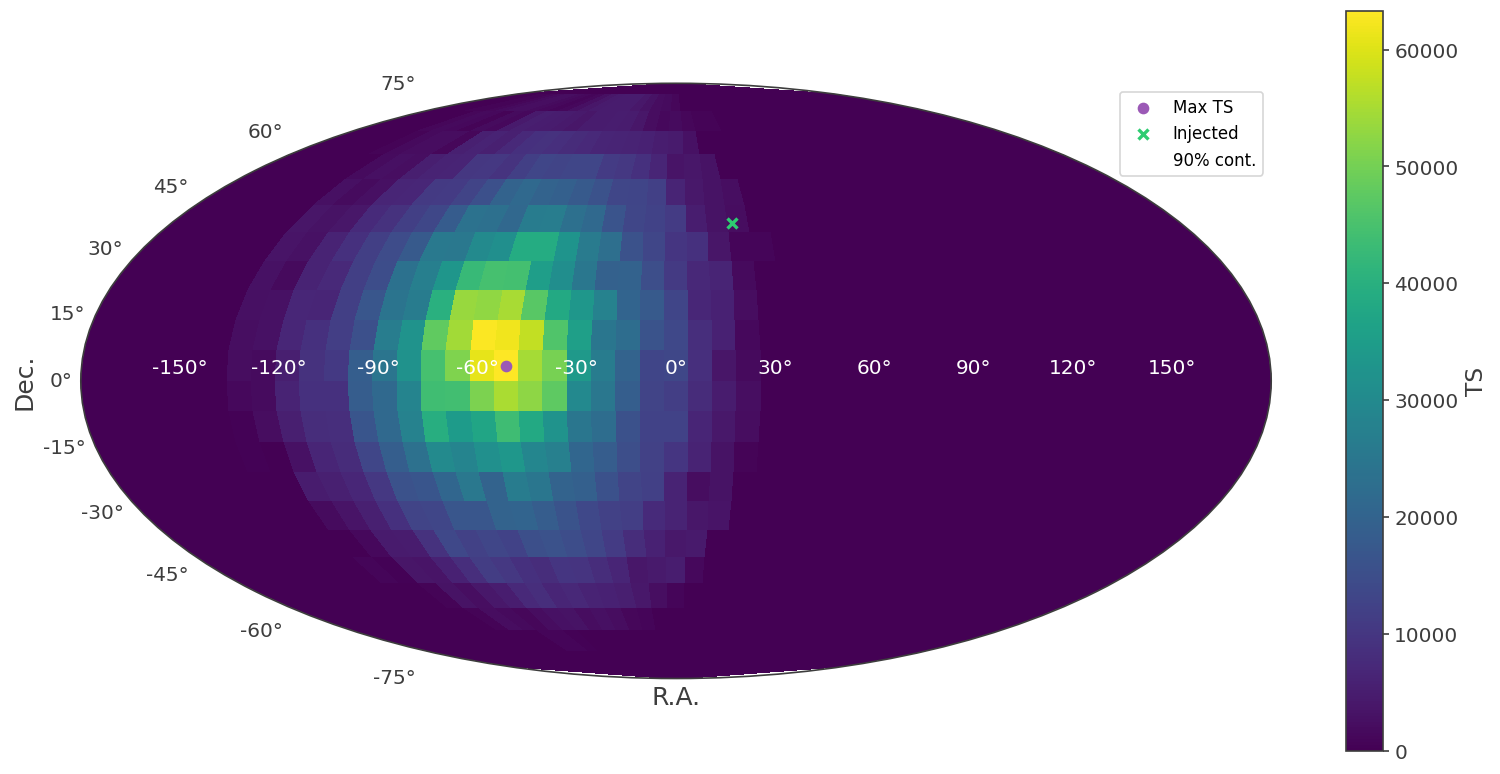

In [39]:
tsmap2.plot_ts_map()